# IMF Midterm 
# Pricing Bermuda Options with Random Walks


Random walks are used in finance to price options in a way that takes into account the volatility of the stock market. 
But what even is an option? what is a random walk? what are the limiations to the simulation and how can we improve it to approximate the real world more closely? 
## Options 

Options are a financial instrument that you or any other investor can use to take market fluctuations into account. It allows you to bet on or insure yourself against an asset's (such as a companies stock or a bitcoin) volatility to protect your portfolio against a price shocks that could be detrimental for your company. 
The basic principle is that against an agreed upon fee (the price of the option) the buyer of the option can either choose to sell or buy the specified asset at an agreed upon strike price after a also determined time period (maturity). For example, one can buy a call option which allows one to buy the asset for an agreed upon price after, say one month. The seller of the option has to sell the option to the holder of the call option while the option holder merely has the, well, option to purchase the asset. The put option is the reverse case, by which the holder of the option is allowed to sell the asset at the agreed price at maturity. 






In [2]:
import random as rd
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
## Random Walk simulation
class OptionSimulation:
    '''
    Simulate the price of options

    '''
    def __init__(self,
                initial_price=100, 
                strike_price=105, #strike price is 
                volatility=0.1, 
                risk_free_rate = .075, 
                maturity = 90, #run for 90 days
                change_in_time = 1/365, # a day  
                walks=1000,
                iterations = 1000):
        '''
        Inputs:

            initial_price (int):    The price of the underlying asset at time 0

            strike_price (int):     The agreed upon strike price at the exercise date. 

            volatility (float):     The volatility of the option that determines the option price

            walks (int):            Number of random walks to be simulated in one simulation.

            risk_free_rate:         The risk free interest that could be earned if the money is put in the bank. 

            maturity:               Length of the option contract. 

        '''
        self.initial_price = initial_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.maturity = maturity
        self.risk_free_rate = risk_free_rate
        self.change_in_time = change_in_time
        self.stock_prices = np.zeros((iterations, self.maturity + 1))
        self.iterations = iterations
        self.expected_value = None
        self.option_price = None



    def simulate(self):

        """
        Simulate the most basic of random walk option pricing models
        Updates the stock prices to a matrix of shape interations x walks
        """ 
        for sim in range(self.iterations):
            self.stock_prices[sim, 0] = self.initial_price
            for day in range(self.maturity):
                self.stock_prices[sim, day + 1] = self.stock_prices[sim, day] * (
                    1 + self.risk_free_rate * self.change_in_time + self.volatility * np.random.normal(0, self.change_in_time ** 0.5))
        
        self.stock_prices = self.stock_prices

    
    def visualise(self):

        # Plot 10 random price walks, showing how the stock price changes with the number of days.
        plt.figure(figsize=(8, 6))

        plt.plot(self.stock_prices[:10].transpose())
        plt.hlines(self.strike_price, xmin = 0, xmax = self.maturity, linestyles = 'dotted', color = 'black')
        plt.text(s ='Strike Price', x = 3, y = self.strike_price + .5, color = 'black')
        plt.title('10 sample stock price random walks')
        plt.xlim(0, self.maturity + 1)  
        plt.xlabel('Number of Days')
        plt.ylabel('Stock Price')

        plt.show() 

    def final_price(self):

        ## calculate the price difference of final day price and strike price and collect earnings if we make any
        self.expected_value = np.mean([max(self.stock_prices[i, -1] - self.strike_price, 0)  for i in range(self.iterations)]) 

        # discount by the growth rate 
        self.option_price = math.e ** (-self.risk_free_rate*(self.maturity/360)) * self.expected_value



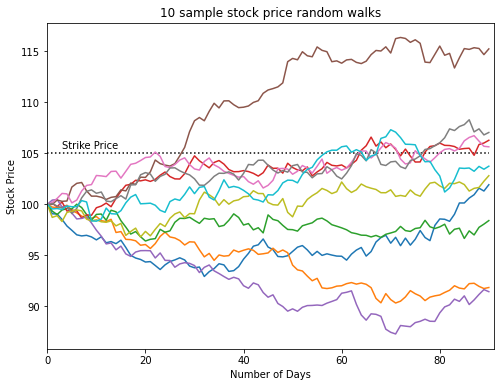

In [4]:
euro_option = OptionSimulation()
euro_option.simulate()
euro_option.visualise()
euro_option.final_price()

In [5]:
euro_option.final_price()

In [6]:
euro_option.stock_prices[:10, -1]

array([101.92550763,  91.84593753,  98.40956267, 106.28357802,
        91.43892204, 115.24370179, 105.64288849, 107.04904741,
       102.80988887, 103.74144405])

In [11]:
## Brute Force approach

#run an initial number of random walks until the first maturity date
BruteForce = OptionSimulation(iterations = 100, maturity = 45)
BruteForce.simulate()

#calculate the price of the option at this 
BruteForce.final_price()

#set up a summation for the expected value
expected_value_nested = 0

#for each end price after first time
for price in BruteForce.stock_prices[:,-1]:

    #simulate the next 45 days with the initial price
    resim = OptionSimulation(initial_price = price, maturity = 45)

    resim.simulate()
    resim.final_price()

    #check if the expected value at the end of the second time period is higher than on the first
    expected_value_nested += max(price - BruteForce.strike_price, resim.expected_value)

#print the value of the full option
print(round(expected_value_nested/len(BruteForce.stock_prices[:,-1]), 3))


0.971


In [24]:

## Brute Force approach

#run an initial number of random walks until the first maturity date
BruteForce = OptionSimulation(iterations = 3, maturity = 45)
BruteForce.simulate()

#calculate the price of the option at this 
BruteForce.final_price()

#set up a summation for the expected value
expected_value_nested = 0

first_half = BruteForce.stock_prices


In [25]:
first_half.shape

(10, 3, 46)

In [70]:
### ONLY FOR VISUALISING

#set up stock price list
full_series = []

#for each end price after first time
for walk in BruteForce.stock_prices:

    price = walk[-1]

    #simulate the next 45 days with the initial price
    resim = OptionSimulation(initial_price = price, maturity = 45, iterations = 10)
    resim.simulate()

    #attach the subwalk to the walk
    for sub_walk in resim.stock_prices:

        full_series.append(np.concatenate((walk, sub_walk[1:])))

#print the value of the full option
print(round(expected_value_nested/len(BruteForce.stock_prices[:,-1]), 3))

20.809


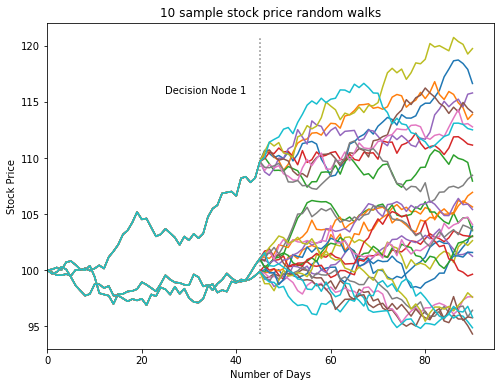

In [71]:
plt.figure(figsize=(8, 6))

plt.plot(np.asarray(full_series).transpose())
plt.vlines(45, ymin = min(np.asarray(full_series).flatten()), ymax = max(np.asarray(full_series).flatten()), linestyle = "dotted", color = 'grey')
plt.text(s ='Decision Node 1', x = 25, y = max(np.asarray(full_series).flatten()) -5, color = 'black')
plt.title('10 sample stock price random walks')
plt.xlim(0)
plt.xlabel('Number of Days')
plt.ylabel('Stock Price')

plt.show()

In [55]:
np.asarray(full_series).shape

(30, 92)

In [56]:
full_series

578,
         99.02235338,  98.99308723,  99.07465373,  99.20293354,
         99.5183279 ,  99.88783621,  99.88783621, 100.64379031,
        101.77093349, 101.84545237, 101.39919134, 100.9736059 ,
        100.61994684, 101.20731781, 101.70759685, 100.6867695 ,
        100.93636691, 100.39348053, 100.43113625, 100.8978151 ,
        101.34752276, 101.79005229, 100.92429514, 100.90464626,
        100.90190197, 101.06219289, 100.99997179, 100.63514061,
        100.88210732, 100.33024843, 101.14024289, 101.19406265,
        101.32556584, 101.74644154, 101.67064277, 102.33370733,
        102.69521947, 103.07375052, 103.47932193, 103.00528775,
        103.64163968, 103.53164616, 103.19325902, 103.11503161,
        103.58140941, 102.89350347, 103.47150248, 102.8256668 ,
        103.59435882, 103.15324318, 102.80175967, 102.95826929]),
 array([100.        , 100.07746949, 100.23997138, 100.02861246,
        100.72069756, 100.81228895, 100.47206271, 100.07910756,
        100.00255391, 100.3965591